# Geospatial Python
## Crop raster data with rioxarray and geopandas
Setup: https://carpentries-incubator.github.io/geospatial-python/index.html

Instruction: https://carpentries-incubator.github.io/geospatial-python/08-crop-raster-data.html

Objectives:
* Crop raster data with a bounding box.
* Crop raster data with a polygon.
* Match two raster datasets in different CRS.

We will use the results of the satellite image search 'search.json', which was generated in 'Geospatial Python 05 - Intro.ipynb'.
And the cropped fields polygons 'fields_cropped.shp', which was generated in 'Geospatial Python 07 - Vector Data - complete.ipynb'.


In [1]:
# first import necessary libraries
import pystac
import rioxarray

# (lazy) Load 6th image from search result and inspect the shape
items = pystac.ItemCollection.from_file("search.json")
raster = rioxarray.open_rasterio(items[5].assets["visual"].href) # Select a true color image
print(raster.shape)

(3, 10980, 10980)


(3, 687, 687)


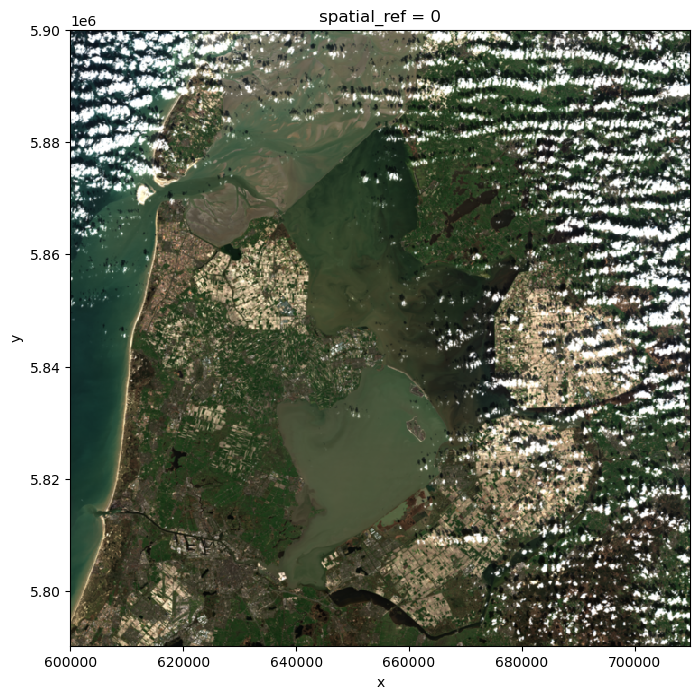

In [2]:
# Get the overview asset
# Note: “Overviews” are precomputed lower resolution representations of a raster, part of COG standard
raster_overview = rioxarray.open_rasterio(items[5].assets["visual"].href, overview_level=3)
print(raster_overview.shape)

# Visualize it
raster_overview.plot.imshow(figsize=(8,8))

In [3]:
# Check the coordinate system of the raster
# this requires pyproj
from pyproj import CRS

CRS(raster.rio.crs)

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# Load and check the coordinate system of the 'fields_cropped.shp' file
import geopandas as gpd

# Load the polygons of the crop fields
fields = gpd.read_file("fields_cropped.shp")

# Check the coordinate system
fields.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [5]:
# Convert the 'fields' CRS to the CRS of 'raster'
fields = fields.to_crs(raster.rio.crs)

## Crop raster data with a bounding box

In [6]:
# Crop the raster with the bounding box
raster_clip_box = raster.rio.clip_box(*fields.total_bounds)
# note the * unpacks the array
print(raster_clip_box.shape)

(3, 1574, 1584)


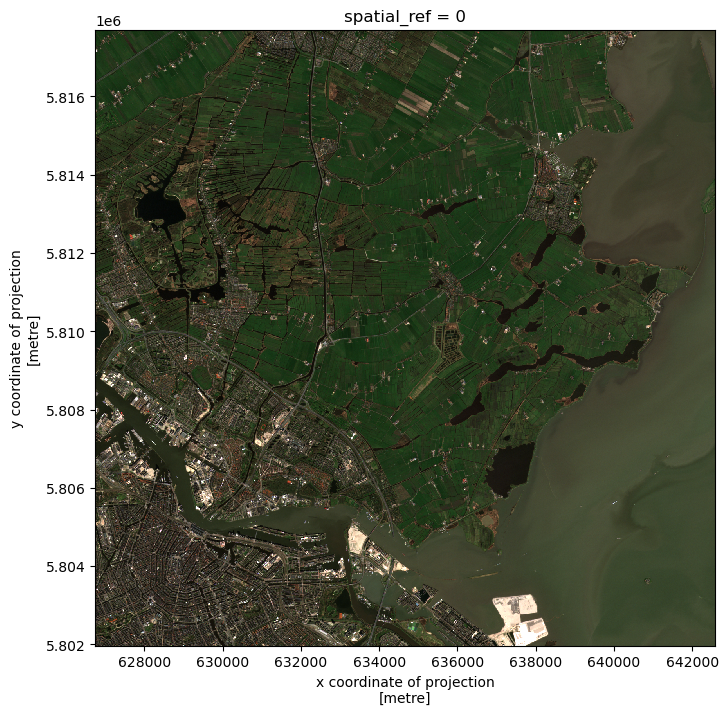

In [7]:
# visualize the result
raster_clip_box.plot.imshow(figsize=(8,8))

In [8]:
# save the cropped tif
raster_clip_box.rio.to_raster("raster_clip.tif")

## Crop raster data with polygons

In [9]:
# crop the image to the exact field boundaries
raster_clip_fields = raster_clip_box.rio.clip(fields['geometry'])

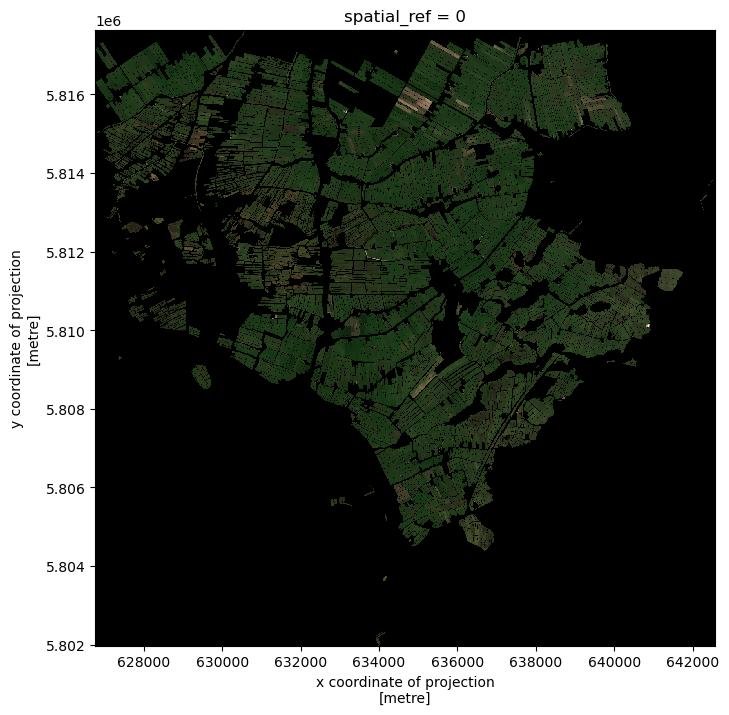

In [10]:
# visualize the result
raster_clip_fields.plot.imshow(figsize=(8,8))

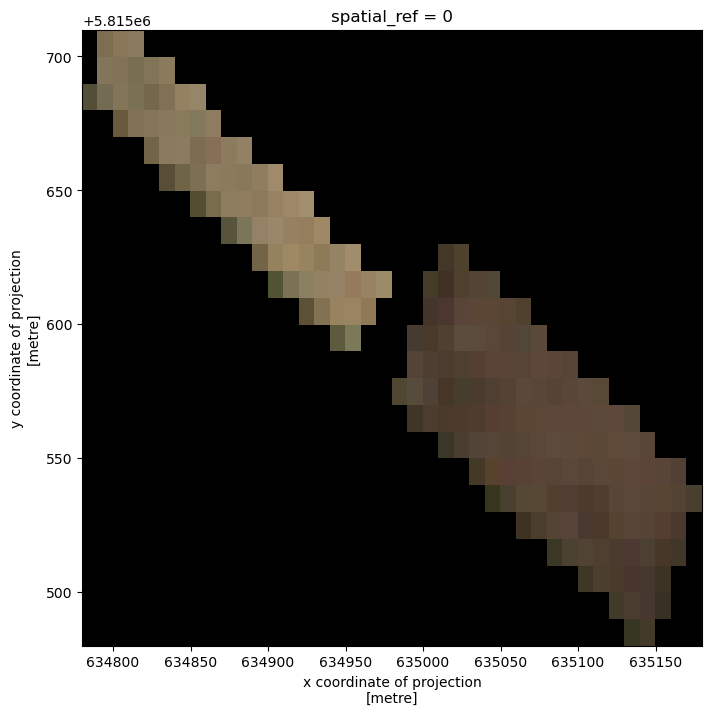

In [11]:
''' Exercise: Crop raster data with a specific "crop code"

In the column “gewascode” (translated as “crop code”) of fields, you can find the code representing the types of plants grown in each field. 
Can you:

- Select the fields with “gewascode” equal to 257;
- Crop the raster raster_clip_box with the selected fields;
* Visualize the cropped image.

'''
mask = fields['gewascode']==257
fields_gwascode = fields.where(mask)
fields_gwascode = fields_gwascode.dropna()
raster_clip_fields_gwascode = raster_clip_box.rio.clip(fields_gwascode['geometry'])
raster_clip_fields_gwascode.plot.imshow(figsize=(8,8))

## Crop raster data using reproject_match() function

In [16]:
# Reproject 'raster_clip_fields_gwascode' to make the CRS different from the "raster"
# Use EPSG:28992
raster_clip_fields_gwascode = raster_clip_fields_gwascode.rio.reproject("EPSG:28992")
CRS(raster_clip_fields_gwascode.rio.crs)

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [17]:
# check the CRS of raster_clip_box
CRS(raster_clip_box.rio.crs)

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

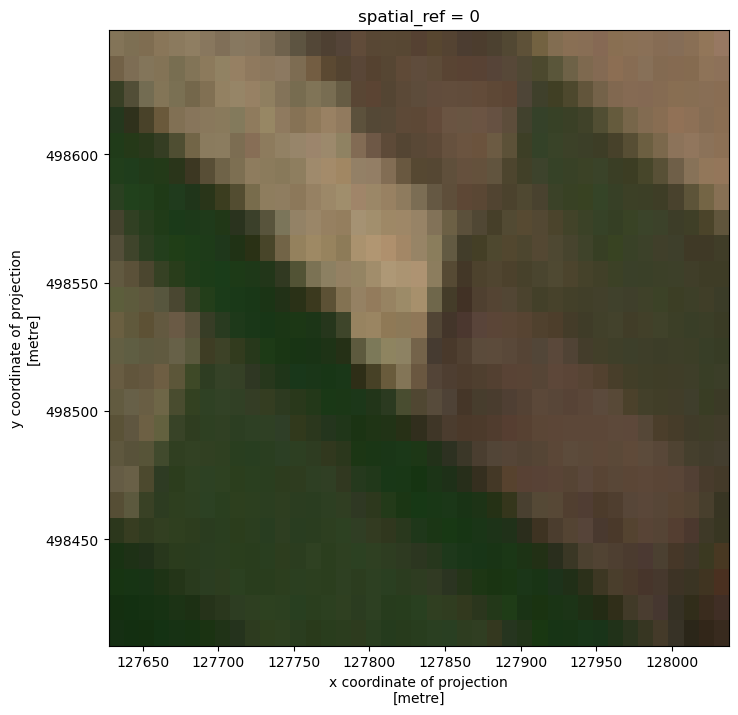

In [18]:
# crop raster_clip_box image agaist raster_clip_fields_gwascode with different projection
raster_reproject_match = raster_clip_box.rio.reproject_match(raster_clip_fields_gwascode)

#visualize the result
raster_reproject_match.plot.imshow(figsize=(8,8))

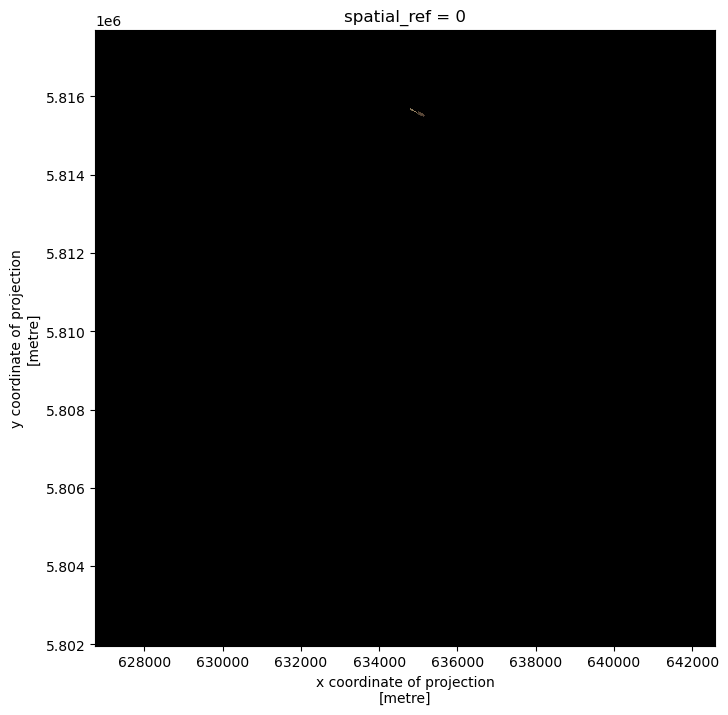

In [15]:
# or go the other way to expand the bounds
raster_reproject_match = raster_clip_fields_gwascode.rio.reproject_match(raster_clip_box)
raster_reproject_match.plot.imshow(figsize=(8,8))